# Variational Quantum Classifier (VQC)


## Explicación

En este notebook se implementa un clasificador cuántico variacional (VQC) con las librerías de Qiskit. Para ello cabe recordar de que VQC es híbrido debido a que mezcla computación cuántica (para la inferencia) con optimización clásica (para el entrenamiento de sus parámetros).

Un **VQC** (o circuito cuántico parametrizado) consta de tres etapas:

*   **Mapa de características**: codifica los entradas clásicas en estados  cuánticos.
*   **Capa variacional**: aplica puertas (rotaciones) cuyos ángulos θ son parámetros aprendidos reduciendo clásicamente una función de pérdida.

*   **Medición**: convierte el estado cuántico final en resultados clásicos (ML clásico) para evaluar la pérdida y actualizar θ.

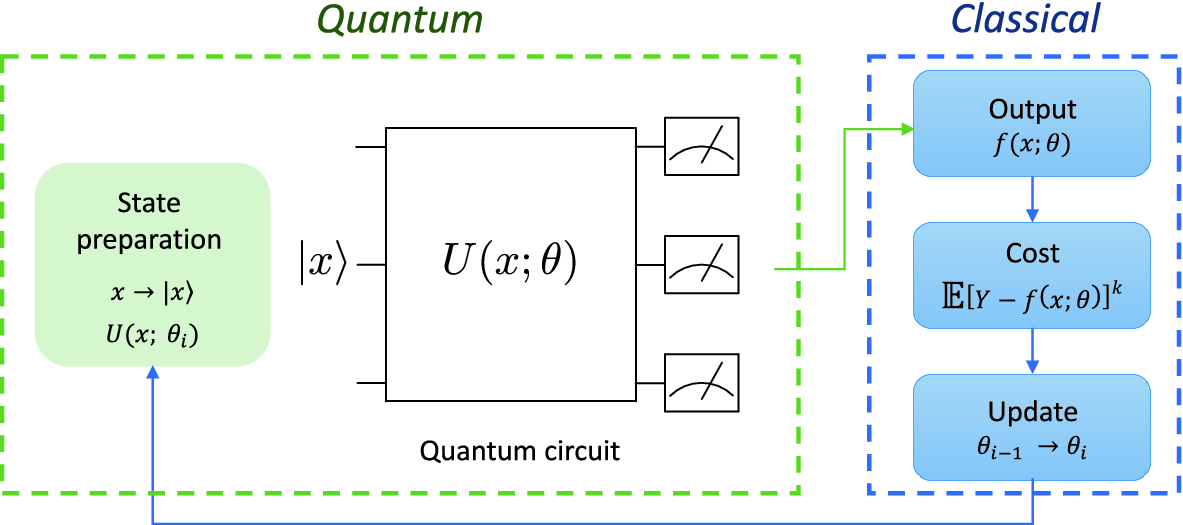

Como ya se mencionó, un VQC es híbrido porque utiliza rutinas clásicas para optimizar sus parámetros según los datos de entrenamiento. Este proceso se ilustra construyendo una función de pérdida clásica a partir de las mediciones finales de los registros cuánticos, que generan datos en formato clásico.

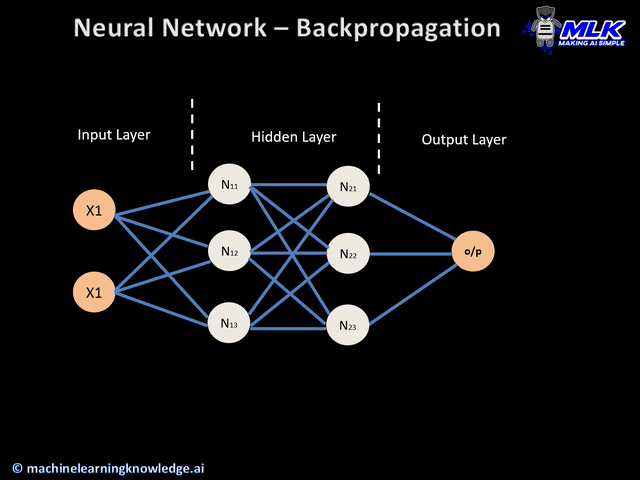

En resumen, podemos decir que el VQC es una red neuronal cuya propagación hacia adelante (forward propagation) es cuántica (ejecutada por un circuito cuántico), mientras que la retropropagación (el paso de optimización para minimizar la función de pérdida) se realiza de forma clásica.

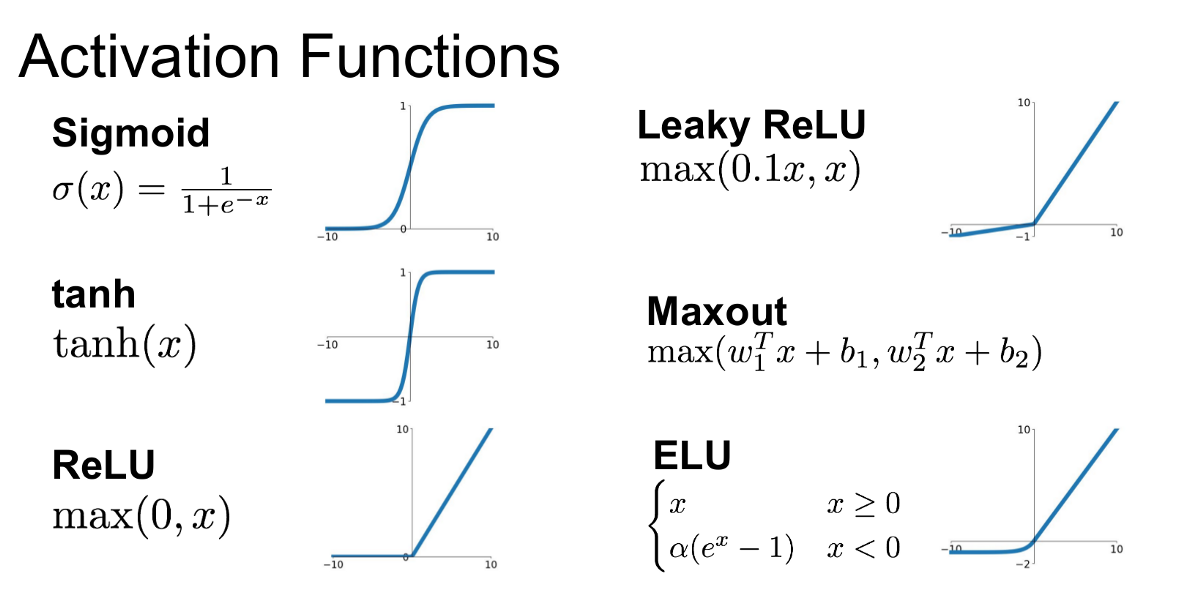

## Exploración del dataset

El dataset que utilizaremos será "Climate Model Simulation Crashes", se trata de un conjunto de datos sobre fallos en simulaciones de un modelo climático. Se usó un método de “hipercubo latino” para probar 18 parámetros diferentes del modelo.

Total de simulaciones: 540 (3 estudios de 180 cada uno)
Fallos registrados: 46 (por errores numéricos)

Columnas:

*   Columna 1-3: Número de estudio 1-3
*   Columna 3-20. Valores de los 18 parámetros, cada uno entre 0 y 1
*   Columna 21: Resultado, 0 = fallo, 1 = éxito

El objetivo será predecir si una simulación fallará (0) o tendrá éxito (1) según los valores de los parámetros de entrada.

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import plotly.express as px

# Visualización correlación
!pip install -U kaleido

In [2]:
FILE_ID = "1a7DndWDsvbyKs1USmWtOp2Q0dbvCVb4n"
file_path = f"https://drive.google.com/uc?export=download&id={FILE_ID}"

df = pd.read_csv(file_path).iloc[:, 1:]
print(df)

     Study  Run  vconst_corr  vconst_2  vconst_3  vconst_4  vconst_5  \
0        1    1     0.859036  0.927825  0.252866  0.298838  0.170521   
1        1    2     0.606041  0.457728  0.359448  0.306957  0.843331   
2        1    3     0.997600  0.373238  0.517399  0.504993  0.618903   
3        1    4     0.783408  0.104055  0.197533  0.421837  0.742056   
4        1    5     0.406250  0.513199  0.061812  0.635837  0.844798   
..     ...  ...          ...       ...       ...       ...       ...   
535      3  176     0.657136  0.489375  0.133713  0.411950  0.087780   
536      3  177     0.915894  0.842720  0.518947  0.090622  0.336981   
537      3  178     0.478600  0.941185  0.769245  0.950776  0.189406   
538      3  179     0.007793  0.779287  0.867468  0.704820  0.983282   
539      3  180     0.608075  0.031556  0.598264  0.794771  0.145680   

     vconst_7   ah_corr  ah_bolus  ...  efficiency_factor  tidal_mix_max  \
0    0.735936  0.428325  0.567947  ...           0.245675  

In [3]:
df = pd.read_csv(file_path).iloc[:, 3:]
print(df)

     vconst_corr  vconst_2  vconst_3  vconst_4  vconst_5  vconst_7   ah_corr  \
0       0.859036  0.927825  0.252866  0.298838  0.170521  0.735936  0.428325   
1       0.606041  0.457728  0.359448  0.306957  0.843331  0.934851  0.444572   
2       0.997600  0.373238  0.517399  0.504993  0.618903  0.605571  0.746225   
3       0.783408  0.104055  0.197533  0.421837  0.742056  0.490828  0.005525   
4       0.406250  0.513199  0.061812  0.635837  0.844798  0.441502  0.191926   
..           ...       ...       ...       ...       ...       ...       ...   
535     0.657136  0.489375  0.133713  0.411950  0.087780  0.356289  0.480204   
536     0.915894  0.842720  0.518947  0.090622  0.336981  0.893576  0.978703   
537     0.478600  0.941185  0.769245  0.950776  0.189406  0.112743  0.745645   
538     0.007793  0.779287  0.867468  0.704820  0.983282  0.420303  0.710612   
539     0.608075  0.031556  0.598264  0.794771  0.145680  0.378183  0.461948   

     ah_bolus  slm_corr  efficiency_fac

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vconst_corr           540 non-null    float64
 1   vconst_2              540 non-null    float64
 2   vconst_3              540 non-null    float64
 3   vconst_4              540 non-null    float64
 4   vconst_5              540 non-null    float64
 5   vconst_7              540 non-null    float64
 6   ah_corr               540 non-null    float64
 7   ah_bolus              540 non-null    float64
 8   slm_corr              540 non-null    float64
 9   efficiency_factor     540 non-null    float64
 10  tidal_mix_max         540 non-null    float64
 11  vertical_decay_scale  540 non-null    float64
 12  convect_corr          540 non-null    float64
 13  bckgrnd_vdc1          540 non-null    float64
 14  bckgrnd_vdc_ban       540 non-null    float64
 15  bckgrnd_vdc_eq        5

In [5]:
df.isnull().any().sum()

np.int64(0)

Como podemos deducir, se trata de un dataset **desbalanceado**: existen 46 casos de fallo frente a 494 de éxito. Esto implica que, al entrenar el clasificador tenderá a predecir siempre la clase mayoritaria (éxito) para maximizar la precisión global de éxito, **de modo que los escasos casos de fallo apenas influirán en el aprendizaje, haciendo muy improbable que el modelo aprenda a detectarlos y, por tanto, obtenga un recall extremadamente bajo para la clase “fallo”.**

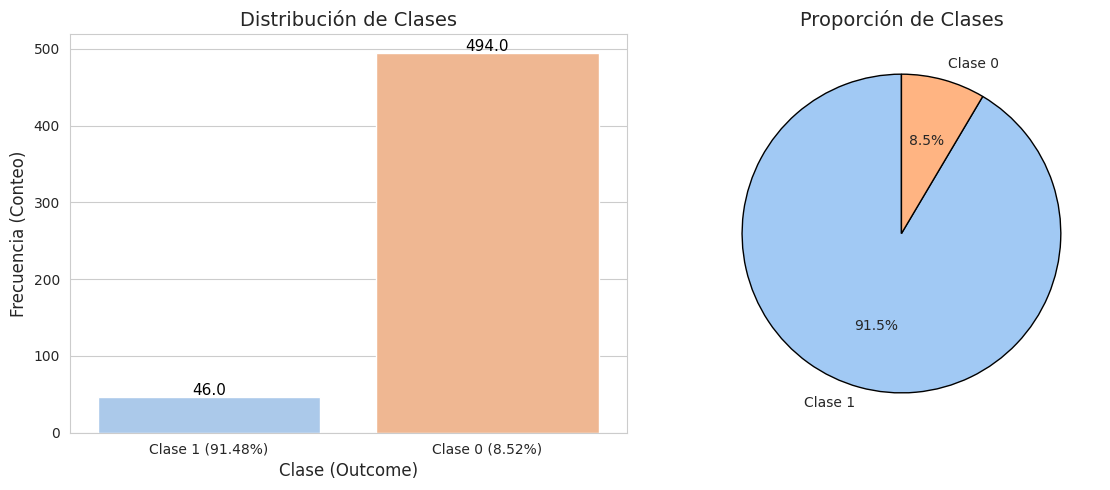



El dataset está claramente desbalanceado.
La clase mayoritaria (Clase '1') representa el 91.48% de los datos (494 instancias).
La clase minoritaria (Clase '0') representa solo el 8.52% de los datos (46 instancias).
Existe una proporción de aproximadamente 10.7:1 entre la clase mayoritaria y la minoritaria.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE


warnings.filterwarnings("ignore", category=UserWarning)

df = pd.DataFrame(df)
counts = df["outcome"].value_counts()
proportions = df["outcome"].value_counts(normalize=True).mul(100).round(2)


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5) # Ajusta el tamaño de las figuras

# 3. Gráfico de Barras
plt.subplot(1, 2, 1) # Crea un subplot (1 fila, 2 columnas, gráfico 1)
ax_bar = sns.countplot(x='outcome', data=df, palette='pastel', hue='outcome', legend=False)
plt.title('Distribución de Clases', fontsize=14)
plt.xlabel('Clase (Outcome)', fontsize=12)
plt.ylabel('Frecuencia (Conteo)', fontsize=12)
for p in ax_bar.patches:
    ax_bar.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
ax_bar.set_xticklabels([f'Clase {label} ({proportions[label]}%)' for label in counts.index], rotation=0)


# 4. Gráfico Circular (Pie Chart)
plt.subplot(1, 2, 2) # Crea un subplot (1 fila, 2 columnas, gráfico 2)
colors = sns.color_palette('pastel')[0:len(counts)]
plt.pie(counts, labels=[f'Clase {idx}' for idx in counts.index], autopct='%1.1f%%',
        startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Proporción de Clases', fontsize=14)
plt.ylabel('')

plt.tight_layout()
plt.show()

minority_class_percentage = proportions.min()
majority_class_percentage = proportions.max()
minority_class_label = proportions.idxmin()
majority_class_label = proportions.idxmax()

print(f"\n\nEl dataset está claramente desbalanceado.")
print(f"La clase mayoritaria (Clase '{majority_class_label}') representa el {majority_class_percentage}% de los datos ({counts[majority_class_label]} instancias).")
print(f"La clase minoritaria (Clase '{minority_class_label}') representa solo el {minority_class_percentage}% de los datos ({counts[minority_class_label]} instancias).")
print(f"Existe una proporción de aproximadamente {counts[majority_class_label]/counts[minority_class_label]:.1f}:1 entre la clase mayoritaria y la minoritaria.")

Para solventar este problema podemos utilizar las para tratar el desbalance:


*   Re-muestreo (oversampling de la clase minoritaria o undersampling de la mayoritaria).
*   Ponderación de clases en la función de pérdida para dar más peso a los fallos.
*   **Generación de ejemplos sintéticos (SMOTE u otros) para equilibrar las clases.**

Dado que tenemos un número pequeño de muestras, no nos conviene hacer Re-muestreo.

Asignarle más weights (peso) no es posible utilizando la versión actual qiskit vqc dado que no es posible modificar parámetros internos.

Por lo que nuestra mejor opción será aplicar SMOTE.


SMOTE (Synthetic Minority Over-sampling Technique) **es un método de sobremuestreo que genera ejemplos sintéticos de la clase minoritaria para balancear un dataset**.


*   Para cada muestra minoritaria, calcula sus k vecinos más cercanos (en el espacio de características).
*   Selecciona al azar uno de esos vecinos y crea un nuevo punto interpolando entre la muestra original y el vecino (en línea recta).
*   Repite hasta alcanzar el balance deseado entre clases.

De este modo, en lugar de duplicar casos, SMOTE introduce variabilidad en la clase minoritaria, ayudando al modelo a aprender mejor sus patrones.

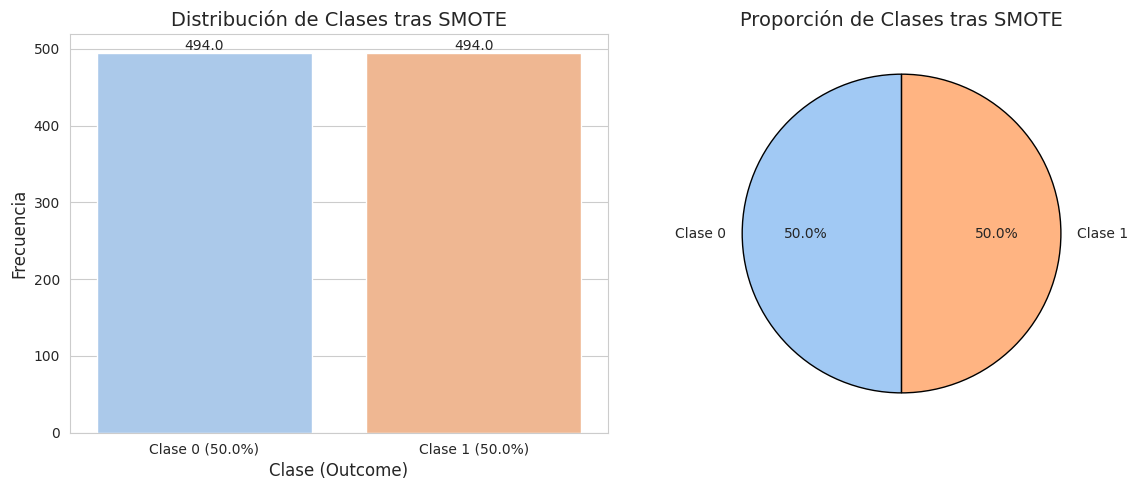

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:,  -1].astype(int).values        # asegúrate de int (0/1)

# ─────────────────────────────── 3) Oversampling SMOTE ──────────────────────────
smote = SMOTE(random_state=42, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X, y)

# 2) Crea un DataFrame con la nueva clase
df_bal = pd.DataFrame({'outcome': y_bal})

# 3) Calcula conteos y proporciones
counts_bal = df_bal['outcome'].value_counts()
props_bal  = df_bal['outcome'].value_counts(normalize=True).mul(100).round(2)

# 4) Dibuja barras y pastel
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# — Gráfico de barras —
plt.subplot(1, 2, 1)
ax = sns.countplot(x='outcome', data=df_bal, palette='pastel', hue='outcome', legend=False)
plt.title('Distribución de Clases tras SMOTE', fontsize=14)
plt.xlabel('Clase (Outcome)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
ax.set_xticklabels([f'Clase {lab} ({props_bal[lab]}%)' for lab in counts_bal.index], rotation=0)

# — Gráfico de pastel —
plt.subplot(1, 2, 2)
colors = sns.color_palette('pastel')[0:len(counts_bal)]
plt.pie(counts_bal,
        labels=[f'Clase {lab}' for lab in counts_bal.index],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'black'})
plt.title('Proporción de Clases tras SMOTE', fontsize=14)
plt.ylabel('')

plt.tight_layout()
plt.show()

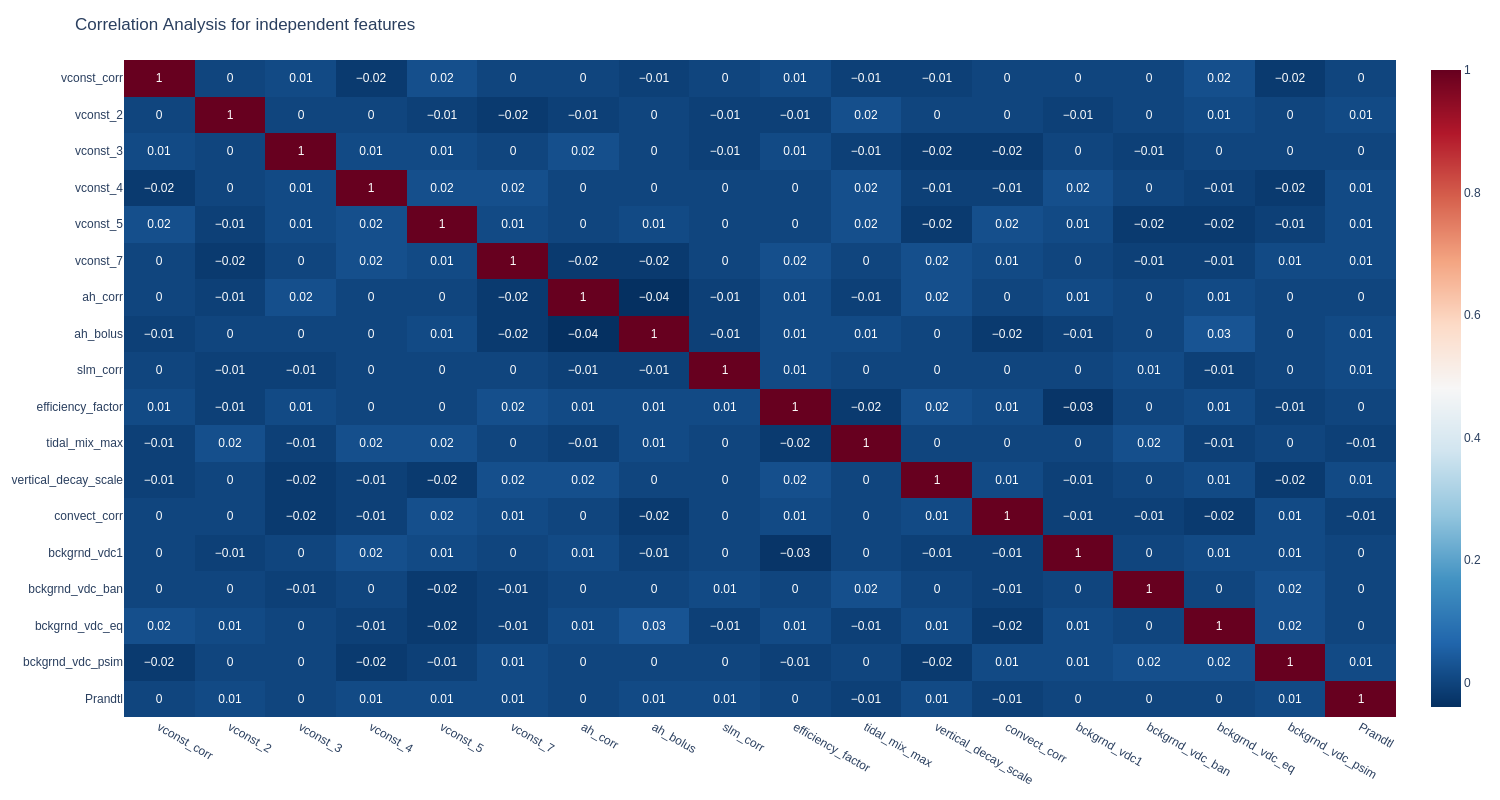

In [8]:
# Create a copy for exploratory data analysis
data_viz = df.copy()

# Heat map showing correlation of features
fig = px.imshow(data_viz.drop('outcome', axis = 1).corr().round(2), text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.update_layout(title = 'Correlation Analysis for independent features', height=800, width=1500)
fig.write_image('fig.png', engine='kaleido')
fig.show('png')

Como se aprecia, **las variables no tienen correlación entre sí**; todos los coeficientes están prácticamente en cero.

## Dimensionalidad del Dataset

El principal problema de este dataset es el número de carácteristicas (18), como sabemos una característica equivale a un qubit y debido a que qiskit nos permite trabajar con como máximo 8 qubits hace inviable entrenar el modelo. Incluso 8 qubits ya es demasiado cada qubit extra duplica el tamaño del espacio de estados y multiplica el número de parámetros θ a optimizar, encareciendo exponencialmente el entrenamiento y haciéndolo inestable.

Por ello, antes de codificar en el circuito **debemos aplicar técnicas de reducción de dimensionalidad—como PCA**—para proyectar las 18 variables originales en un conjunto reducido de componentes principales (por ejemplo 6 u 8) que concentren la mayor parte de la varianza, de modo que podamos usar un número razonable de qubits y mantener el entrenamiento factible tanto en tiempo como en recursos.

Primero evaluaremos cuánto porcentaje de varianza capturan las dimensionalidades con PCA 3, 4 y 8

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np, pandas as pd

# ----------------------------------------------
# 1. Separar X / y y elegir las 3 features
# ----------------------------------------------
y        = df["outcome"]
cols_top3 = ["vconst_corr", "vconst_2", "bckgrnd_vdc1"]
X_full   = df.drop(columns="outcome")
X3       = df[cols_top3]

# ----------------------------------------------
# 2. Estandarizar
# ----------------------------------------------
X_std  = StandardScaler().fit_transform(X_full)
X3_std = StandardScaler().fit_transform(X3)

# ----------------------------------------------
# 3. PCA sobre el conjunto completo
# ----------------------------------------------
pca_all = PCA().fit(X_std)
cumvar  = pca_all.explained_variance_ratio_.cumsum()

print(f"Var.exp. primeras 3 comp.  : {cumvar[2]:.2%}")
print(f"Var.exp. primeras 4 comp.  : {cumvar[3]:.2%}")
print(f"Var.exp. primeras 8 comp.  : {cumvar[7]:.2%}")



Var.exp. primeras 3 comp.  : 17.84%
Var.exp. primeras 4 comp.  : 23.66%
Var.exp. primeras 8 comp.  : 46.40%


**Como podemos observar, PCA con 8 componentes solo captura el 46,40 % de la varianza total, dejando sin representar más de la mitad (53,60 %) de la información estadística de las 18 variables originales.**

El estudio de Paja et al. (2016) analizó el dataset con Boruta y determinó que, de los 18 parámetros, **solo tres (V1 = vconst_corr, V2 = vconst_2 y V14 = bckgrnd_vdc1) son verdaderamente influyentes**; otros resultaron redundantes y dos no aportan información relevante.

A continuación evaluaremos la importancia de estas tres variables y las compararemos con los resultados de PCA.

Medimos la información mutua entre cada variable de entrada y el resultado (fallo/éxito) para cuantificar su relevancia predictiva.

In [10]:
from sklearn.feature_selection import mutual_info_classif
mi_vals = mutual_info_classif(df.drop("outcome", axis=1), df["outcome"], random_state=0)
mi_series = pd.Series(mi_vals, index=df.columns[:-1]).sort_values(ascending=False)
print("Top 8 por Mutual Information:")
print(mi_series.head(8).round(4))

Top 8 por Mutual Information:
vconst_corr          0.0701
vconst_2             0.0537
bckgrnd_vdc_ban      0.0187
convect_corr         0.0164
efficiency_factor    0.0138
bckgrnd_vdc1         0.0130
slm_corr             0.0099
vconst_7             0.0075
dtype: float64


Calculamos el F-score (ANOVA) entre cada variable y la clase (fallo/éxito) para evaluar su capacidad discriminativa.

*capacidad discriminativa: cuánta “separación” aporta cada característica al problema de clasificación.*

In [11]:
from sklearn.feature_selection import f_classif
f_vals, _ = f_classif(df.drop("outcome", axis=1), df["outcome"])
print("Top 8 F‑score:")
print(pd.Series(f_vals, index=df.columns[:-1]).sort_values(ascending=False).head(8).round(2))

Top 8 F‑score:
vconst_corr         55.10
vconst_2            54.14
convect_corr        20.79
bckgrnd_vdc1        18.90
bckgrnd_vdc_eq       3.34
vconst_4             2.83
bckgrnd_vdc_psim     1.80
vconst_5             1.60
dtype: float64


Calculamos la diferencia absoluta entre las medias de cada variable en las simulaciones exitosas (clase 1) y fallidas (clase 0) para evaluar su capacidad discriminativa.

In [12]:
means_0 = df[df.outcome == 0].mean()
means_1 = df[df.outcome == 1].mean()
diff = (means_1 - means_0).abs().sort_values(ascending=False)
print("Top 6 diferencia |media clase1 – clase0|:")
print(diff.head(6).round(3))

Top 6 diferencia |media clase1 – clase0|:
outcome           1.000
vconst_corr       0.315
vconst_2          0.313
convect_corr      0.199
bckgrnd_vdc1      0.191
bckgrnd_vdc_eq    0.081
dtype: float64


Los tres parámetros vconst_corr, vconst_2 y bckgrnd_vdc1 (los “top-3” que Boruta marcó como fuertemente relevantes) producen, en validación cruzada, una balanced-accuracy ≈ 0 .66, mientras que las tres primeras componentes de PCA sólo alcanzan ≈ 0 .51.
Esto ocurre porque PCA selecciona direcciones de máxima varianza sin mirar la etiqueta, de modo que puede ignorar dimensiones poco variables pero altamente discriminativas Cross Validated Medium.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import pandas as pd

y        = df["outcome"]
X_full   = df.drop(columns="outcome")
cols3    = ["vconst_corr", "vconst_2", "bckgrnd_vdc1"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rf = RandomForestClassifier(n_estimators=400, random_state=0)

def bal_acc(pipe, X):
    return cross_val_score(pipe, X, y, cv=cv,
                           scoring="balanced_accuracy").mean()

pipe_3   = make_pipeline(StandardScaler(), rf)
pipe_p3  = make_pipeline(StandardScaler(), PCA(n_components=3, random_state=0), rf)
pipe_p4  = make_pipeline(StandardScaler(), PCA(n_components=4, random_state=0), rf)
pipe_p8  = make_pipeline(StandardScaler(), PCA(n_components=8, random_state=0), rf)

scores = pd.Series({
    "top-3" : bal_acc(pipe_3,  df[cols3]),
    "PCA-3" : bal_acc(pipe_p3, X_full),
    "PCA-4" : bal_acc(pipe_p4, X_full),
    "PCA-8" : bal_acc(pipe_p8, X_full)
}).sort_values(ascending=False)

print(scores)


top-3    0.666232
PCA-3    0.511111
PCA-8    0.511111
PCA-4    0.509081
dtype: float64


Usamos ROC y Precision-Recall porque en un dataset desbalanceado y usar la precisión puede darnos un resultado engañoso: la ROC evalúa la capacidad de separar ambas clases en distintos umbrales, y la PR pone énfasis en el desempeño sobre la clase minoritaria (fallos).

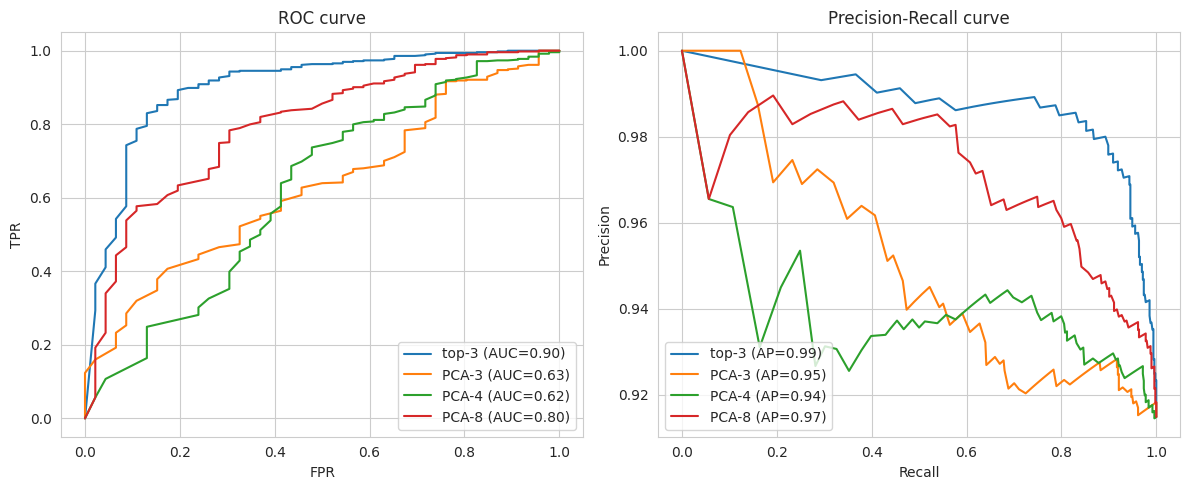

,ROC-AUC,PR-AUC
modelo,,
top-3,0.901756,0.986594
PCA-3,0.629797,0.950430
PCA-4,0.623438,0.938293
PCA-8,0.798143,0.971466


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, roc_curve,
                             average_precision_score, precision_recall_curve)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import pandas as pd

cols3 = ["vconst_corr","vconst_2","bckgrnd_vdc1"]
X_top3 = df[cols3]
X_full = df.drop(columns="outcome")
y      = df["outcome"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
base_clf = RandomForestClassifier(n_estimators=400, random_state=0)

def cv_probs(pipe, X):
    """obtiene probabilidad clase 1 para cada muestra (predicción CV)"""
    return cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:,1]

def model_pipeline(pca_k=None):
    if pca_k is None:
        return make_pipeline(StandardScaler(), base_clf)
    return make_pipeline(StandardScaler(),
                         PCA(n_components=pca_k, random_state=0),
                         base_clf)

models = {
    "top-3":  (model_pipeline(),     X_top3),
    "PCA-3":  (model_pipeline(3),    X_full),
    "PCA-4":  (model_pipeline(4),    X_full),
    "PCA-8":  (model_pipeline(8),    X_full),
}

metrics = []
plt.figure(figsize=(12,5))

for name,(pipe,X) in models.items():
    proba = cv_probs(pipe, X)
    auc   = roc_auc_score(y, proba)
    ap    = average_precision_score(y, proba)
    metrics.append([name, auc, ap])

    fpr, tpr, _ = roc_curve(y, proba)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    prec, rec, _ = precision_recall_curve(y, proba)
    plt.subplot(1,2,2)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.2f})")

# ── formato gráficos ──────────────────────────
plt.subplot(1,2,1)
plt.title("ROC curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.subplot(1,2,2)
plt.title("Precision-Recall curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout(); plt.show()

# ── tabla resultados ───────────────────────────
res_df = pd.DataFrame(metrics, columns=["modelo","ROC-AUC","PR-AUC"]).set_index("modelo")
display(res_df)

In [15]:
print(df.describe().T.sort_values("std", ascending=False).head(10))

                      count      mean       std       min       25%       50%  \
tidal_mix_max         540.0  0.499984  0.289127  0.000419  0.251676  0.500322   
vconst_3              540.0  0.500027  0.289067  0.001181  0.251540  0.500104   
vertical_decay_scale  540.0  0.500032  0.289014  0.001188  0.249669  0.500151   
Prandtl               540.0  0.500021  0.289013  0.000263  0.249723  0.499431   
ah_corr               540.0  0.500059  0.289010  0.004590  0.253048  0.499070   
vconst_4              540.0  0.500119  0.288993  0.001972  0.250158  0.500456   
efficiency_factor     540.0  0.500111  0.288966  0.002015  0.250758  0.500393   
bckgrnd_vdc1          540.0  0.499944  0.288949  0.002509  0.249586  0.499080   
vconst_corr           540.0  0.500026  0.288939  0.000414  0.249650  0.499998   
bckgrnd_vdc_psim      540.0  0.500020  0.288936  0.000219  0.252739  0.498955   

                           75%       max  
tidal_mix_max         0.749346  0.999942  
vconst_3              

In [16]:
!pip install "qiskit==1.4.2" "qiskit-machine-learning==0.8.2"
!pip install -q qiskit-aer pylatexenc

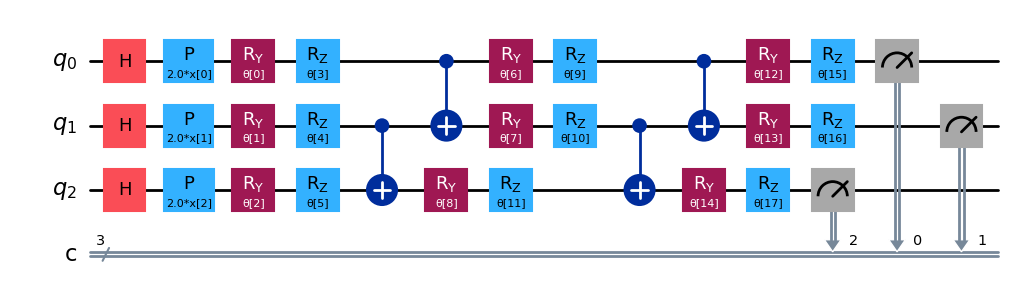

In [18]:
## ejemplo con fila 27 de la experimentación (la mejor en SPSA)
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, EfficientSU2

# Parámetros “fila 27”
n_qubits     = 3
feature_reps = 1
ansatz_reps  = 2

feature_map = ZFeatureMap(feature_dimension=n_qubits, reps=feature_reps)
ansatz      = EfficientSU2(num_qubits=n_qubits, reps=ansatz_reps)

qc = QuantumCircuit(n_qubits, n_qubits)
qc.append(feature_map, range(n_qubits))
qc.append(ansatz,      range(n_qubits))
qc.measure(range(n_qubits), range(n_qubits))

# Despliega un nivel de subcircuitos
qc1 = qc.decompose()

#    vuelve a descomponer para llegar a las puertas básicas
qc2 = qc1.decompose()

qc2.draw("mpl")


1.   **Codificación de la característica (ZFeatureMap=1)**:

Cada qubit (qi) recibe su valor (xi) mediante un Hadamard (HH) seguido de un PhaseGate (P (2xi)) que equivale a una rotación RZ(2xi)
2.   **Ansatz EfficientSU2 (reps=2)**

Capa de rotaciones: en cada qubit se aplica primero RY(θ) y luego RZ(θ).

Entrelazado: una cadena de CNOTs lineal conecta q0→q1 y q1→q2.
Se repite ese bloque dos veces, usando parámetros distintos en cada repetición.
3.   **Medición**:

Al final se mide cada qubit en su bit clásico correspondiente, obteniendo el resultado binario (fallo/éxito).


## Diccionario de parámetros:
loss_func_list: lista de funciones de pérdida
- cross_entropy: típica (mide la discrepancia entre distribuciones).
- absolute_error: error absoluto medio.
- squared_error: error cuadrático medio.

feature_map_list: tipos de mapeo de características (encode clásico a cuántico)
- ZFeatureMap: rotaciones RZ(2xi) tras Hadamard.
- ZZFeatureMap: incluye también rotaciones ZZ para correlaciones par a par.
- PauliFeatureMap: generaliza a rotaciones en distintos ejes de Pauli según un operador compuesto.

ansatz_list: arquitecturas variacionales parametrizadas
- EfficientSU2: capas alternas de RY, RZ y CNOT en línea.
- RealAmplitudes: capas de rotaciones reales RY y entrelazado, más simples.

simulator_list: back-ends para ejecutar/simular el circuito
- qasm-simulator: simulador clásico de Qiskit sin corrección de ruido.
- aer-simulator: simulador avanzado (Qiskit Aer) con opciones de ruido y mitigación.

optimizer_list: optimizadores clásicos
- ADAM
- SPSA
- L_BFGS_B

rep_fm y rep_ans: número de repeticiones (layers) de los bloques

maxiter: número máximo de iteraciones

## Comparativa de resultados con otros modelos

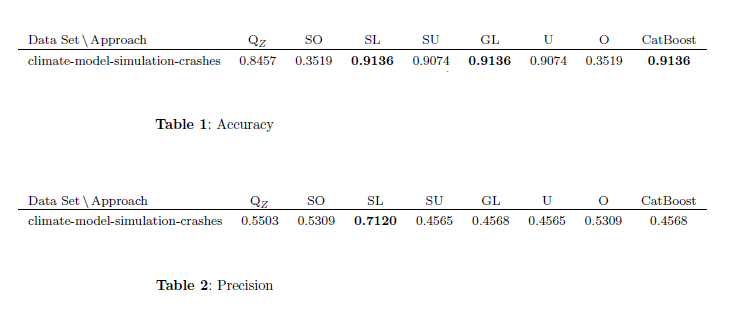 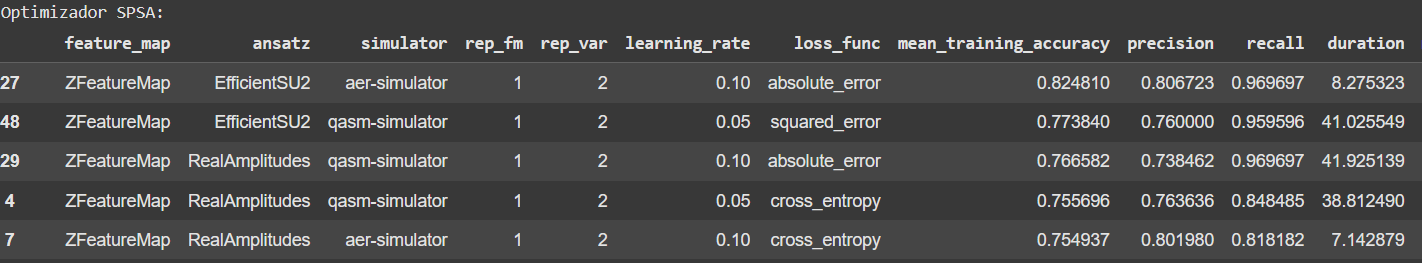
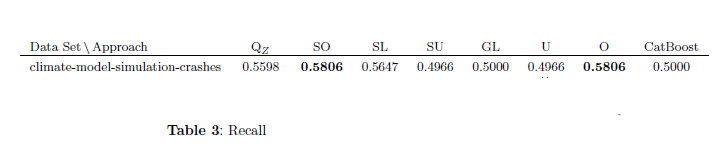
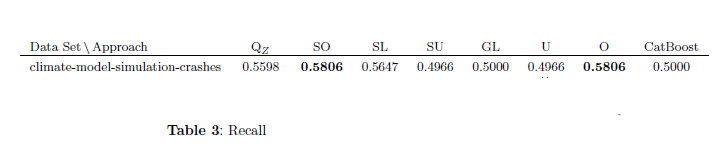

Accuracy (me supera debido al número pequeño de iter):
- SPSA logra 82,48 %
- (SL, SU, GL) y ML Clásico CatBoost alcanzaban hasta 91,36 %

Precisión (mi modelo le supera):
- Con SPSA+ZFeatureMap+EfficientSU2: 80,67 %, y con L_BFGS_B: 83,66 %
- el mayor suyo es cuántico clásico (SL) da 71,20 % de precision.

Recall (mi modelo le supera por mucho):
- SL maximo 56,47 % de recall.
- 96,97 % con SPSA y 87,88 % con L_BFGS_B, **se detectan casi todos los fallos.**